In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_mnist():
    with np.load(f"mnist.npz") as f:
        images, labels = f["x_train"], f["y_train"]
    images = images.astype("float32") / 255
    images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))
    labels = np.eye(10)[labels]
    return images, labels

def convert_to_input(img):
    from PIL import Image
    im1 = Image.open(img)
    return ( 255 - np.array(im1.getdata(0)) )/ 255

class Perceptron():
    def __init__(self, Nodes):
        # The weights are between -1 and 1 at the beginning
        self.nodes_list = Nodes
        self.weights = self.weights_init()
        self.guessed = {}
        
    def weights_init(self):
        out = {}
        for i in range(1, len(self.nodes_list)):
            w = np.array(2 * np.random.rand(self.nodes_list[i], self.nodes_list[i-1]) - 1)
            b = np.array(2 * np.random.rand(self.nodes_list[i], 1                   ) - 1)
            key_1 = 'w{}'.format(i)
            key_2 = 'b{}'.format(i)
            out[key_1] = w
            out[key_2] = b
        return out
    
    def train(self, training_input, training_output, training_iterations):
        for it in range(training_iterations):
            key_t = 't{}'.format(it)
            self.guessed[key_t] = 0
            for L0, Llast_Train in zip(training_input, training_output):
                L0 = np.array(L0, ndmin=2)
                
                steps_dict  = {}            
                prev_key_L = 'L0'
                steps_dict[prev_key_L] = L0
                for i in range(1,len(self.nodes_list)):
                    key_L = 'L{}'.format(i)
                    key_w = 'w{}'.format(i)
                    key_b = 'b{}'.format(i)
                    steps_dict[key_L] = self.step(steps_dict[prev_key_L], self.weights[key_w], self.weights[key_b])
                    
                    prev_key_L = key_L
                
                self.guessed[key_t] += int(np.argmax(steps_dict[key_L]) == np.argmax(Llast_Train))
                
                errors_dict = {}
                deltas_dict = {}
                
                prev_key_e = 'e{}'.format(len(self.nodes_list)-1)    
                prev_key_d = 'd{}'.format(len(self.nodes_list)-1)    
                errors_dict[prev_key_e] = Llast_Train - steps_dict[key_L]
                deltas_dict[prev_key_d] = self.delta(errors_dict[prev_key_e], steps_dict[key_L])
                for i in range(len(self.nodes_list)-2,-1,-1):
                    key_e = 'e{}'.format(i)
                    key_d = 'd{}'.format(i)
                    key_w = 'w{}'.format(i+1)
                    key_L = 'L{}'.format(i)
                    errors_dict[key_e] = np.dot(deltas_dict[prev_key_d], self.weights[key_w])
                    deltas_dict[key_d] = self.delta(errors_dict[key_e], steps_dict[key_L])
                    
                    prev_key_d = key_d
                
                for i in range(len(self.nodes_list)-2,-1,-1):
                    key_w = 'w{}'.format(i+1)
                    key_L = 'L{}'.format(i)
                    key_d = 'd{}'.format(i+1)
                    key_b = 'b{}'.format(i+1)
                    self.weights[key_w] += np.dot(steps_dict[key_L].T, deltas_dict[key_d]).T
                    self.weights[key_b] += np.dot(1, deltas_dict[key_d]).T
            self.guessed[key_t] = self.guessed[key_t] / len(training_input)
            print(f'In the epoch number {it+1}, {round(self.guessed[key_t]*100, 2)} percent of the training inputs were guessed right.')

        
        
    def step(self, layer_in, weights, bias):
        layer_out = self.norm( np.dot(layer_in , weights.T)  + bias.T )
        return layer_out
    
    def guess(self, input_data):
        out = input_data
        for i in range(1,len(self.nodes_list)):
            key_w = 'w{}'.format(i)
            key_b = 'b{}'.format(i)
            out = self.step(out, self.weights[key_w], self.weights[key_b])
        return out
    
    def delta(self, error, output_layer):
        return np.multiply(error, self.norm_deriv(output_layer))

    def norm(self, x):
        return 1 / (1 + np.exp(-x))

    def norm_deriv(self, x):
        return x * (1 - x)

    
    
images, labels = get_mnist()

In [2]:
HiddenNodes = [784, 40, 10]
N = Perceptron(HiddenNodes)

training_inputs = images[:59500]
training_output = labels[:59500]
training_iterations = 4

test_inputs = images[59500:]
test_output = labels[59500:]

N.train(training_inputs, training_output, training_iterations)

In the epoch number 1, 89.41 percent of the training inputs were guessed right.
In the epoch number 2, 92.75 percent of the training inputs were guessed right.
In the epoch number 3, 93.58 percent of the training inputs were guessed right.
In the epoch number 4, 93.71 percent of the training inputs were guessed right.


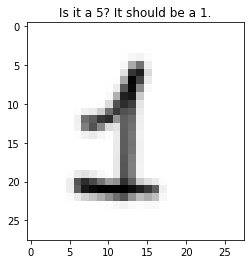

In [3]:
img_from_file    = convert_to_input('test/1.png')
output_from_file =1

output = N.guess(img_from_file)
plt.imshow(img_from_file.reshape(28, 28), cmap="Greys")
plt.title(f"Is it a {output.argmax()}? It should be a {output_from_file}.");

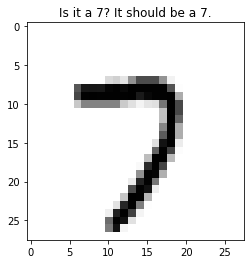

In [7]:
index = np.random.randint(59500, 60000+1)

img = images[index]
lbl = labels[index]

output = N.guess(img)

plt.imshow(img.reshape(28, 28), cmap="Greys")
plt.title(f"Is it a {output.argmax()}? It should be a {lbl.argmax()}.")
plt.show()